In [1]:
%pip install openai pillow



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [82]:
from openai import OpenAI
import json

from ultralytics import YOLO
import os
import yaml
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import base64

from PIL import Image, ImageDraw, ImageFont
from ultralytics.utils.plotting import Annotator
import textwrap

### Setup and constants

In [2]:
# Load api Key
def get_credentials() -> dict:
    # loads openai credentials from local config.json file
    with open('config.json', 'r') as f:
        config = json.load(f)
    return config

In [4]:
config = get_credentials()

client = OpenAI(
  api_key=config['open_api_key']
)

In [330]:
LLM_MODEL = "gpt-4o-mini"
model = YOLO("yolo11n.pt")
FONT_PATH = "data/Virgil.ttf"  # Path to your .ttf font file

INTERIOR_CLASSES = {
    13: ('bench', (0, 255, 255)),          # Yellow
    56: ('chair', (255, 0, 0)),            # Red
    57: ('couch', (0, 255, 0)),            # Green
    58: ('potted plant', (255, 165, 0)),   # Orange
    59: ('bed', (255, 0, 255)),            # Magenta
    60: ('dining table', (0, 0, 255)),     # Blue
    61: ('toilet', (0, 128, 255)),         # Light Orange
    62: ('tv', (128, 0, 128)),             # Purple
    63: ('laptop', (0, 255, 128)),         # Light Green
    67: ('cell phone', (255, 192, 203)),   # Pink
    72: ('refrigerator', (0, 128, 0)),     # Dark Green
    75: ('vase', (128, 128, 0))            # Olive
}


In [306]:
furniture_list = {INTERIOR_CLASSES[key][0] for key in INTERIOR_CLASSES}
print("furniture list is: ", furniture_list)

furniture list is:  {'bench', 'chair', 'potted plant', 'cell phone', 'couch', 'vase', 'laptop', 'refrigerator', 'dining table', 'tv', 'bed', 'toilet'}


## Helper Functions

### Helper Functions

In [307]:
def get_prompt(detected_classes):
    prompt = f"""
    Based on Feng Shui principles, provide brief, specific recommendations to improve the energy flow and harmony of the room. 
    Only comment if you have useful recommendations. 

    Follow these principles as a guideline
    Dos
    1. Maximize Light Exposure: Position furniture to allow for maximum natural light.
    2. Incorporate Plants: Use plants like aloe vera, bamboo, or ficus to promote positive energy flow.
    3. Element of Fire: Include elements representing fire to promote passion and energy.
    4. Functional Design: Ensure the room layout allows for maximum comfort and enjoyment.
    5. Keep it Clean: Maintain a clutter-free environment for better energy flow.
    6. Element of Earth: Incorporate earth elements to promote stability and balance.
    7. Commanding Position: Place furniture so you can see the door from where you're sitting.
    8. Mindful TV Placement: Mount TVs appropriately to avoid crowding and distractions.
    9. Create Balance: Use a mix of light and dark colors, and hard and soft furnishings.
    10. Thoughtful Color Choices: Select colors that promote the desired energy (e.g., blue for calmness, red for energy).

    Don'ts
    1. Overuse Colors: Avoid using too many colors to prevent a chaotic atmosphere.
    2. Excessive Furniture: Don't overcrowd the room; use only necessary pieces.
    3. Ignore Energy Flow: Arrange furniture to allow smooth and uninterrupted energy flow.
    4. Furniture Against Walls: Leave space between furniture and walls to avoid blocking energy.
    5. High-Hung Artwork: Hang photos and artwork at eye level to prevent scattered energy.
    
    Assess the key fenghsui principles to see if one of the major points are missing from the photo, if so, add address it as a general recommendation.
    Only output the recommendations in JSON format with keys as the names of the furniture you have suggestions for that are present in the image.
    image classes: {detected_classes}.

    Example response:
    {{
        "bed": "The bed should be facing the entrance, not the wall."
        "general": "Try adding a potted plant to improve the energy"
    }}
    """
    return prompt
    
    
def encode_image(image):
    _, buffer = cv2.imencode('.jpg', image)
    return base64.b64encode(buffer).decode('utf-8')


def get_gpt4_completion_with_image(image, detected_classes):
    base64_image = encode_image(image)
    image_data_url = f"data:image/jpeg;base64,{base64_image}"
    
    completion = client.chat.completions.create(
        
        model=LLM_MODEL,
        messages=[
            {"role": "system", "content": "You are a Feng Shui expert who helps customers re-arrange their room according to Feng Shui principles."},
            {"role": "user",
             "content": [
                        {
                            "type": "text",
                            "text": get_prompt(detected_classes),
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": image_data_url
                            },
                        },
                    ], 
             },
        ],
        response_format= { "type": "json_object" },
        max_tokens=200,
    )

    try:
        response_json = json.loads(completion.model_dump_json(indent=2))
        content_json = json.loads(response_json['choices'][0]['message']['content'])
        return content_json
    except Exception as e:
        return None
    

In [400]:
def detect_objects(image):
    """
    Implemented custom detection and drawing of bounding boxes.
    Only drawing items if they are in INTERIOR_CLASSES.
    """
    results = model(image)
    detected_items = {}

    # Initialize annotator before the loop
    annotator = Annotator(image)

    for result in results:
        for box in result.boxes:
            class_id = int(box.cls)
            if class_id in INTERIOR_CLASSES:
                label, color = INTERIOR_CLASSES[class_id]

                if label not in detected_items:
                    detected_items[label] = []

                # Extract bounding box coordinates
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                detected_items[label].append((x1, y1, x2, y2))

                # Draw the bounding box and label using annotator
                annotator.box_label(box.xyxy[0], label, color=color)

    # Get the annotated image from the annotator
    annotated_image = annotator.result()

    return annotated_image, detected_items

#### Get Annotated Image

In [401]:
example_path = 'data/examples'
# Good examples: 1, 2, 4!, 6
# example [3, 5] bug
sample_image_path = os.path.join(example_path, os.listdir(example_path)[7])
image = Image.open(sample_image_path)


0: 384x640 2 couchs, 1 microwave, 32.8ms
Speed: 1.8ms preprocess, 32.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


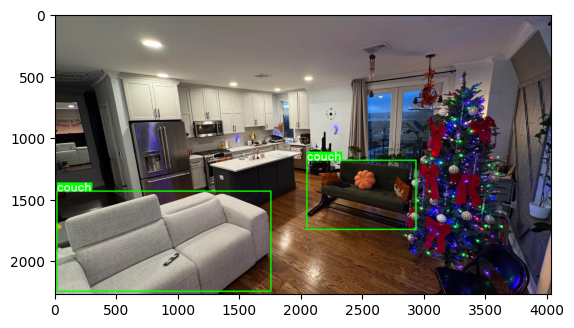

{'couch': [(2043, 1184, 2928, 1744), (15, 1434, 1751, 2245)]}


In [402]:
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_future = Image.fromarray(image)
annotated_image, detected_items = detect_objects(image)
plt.imshow(annotated_image)
plt.show()
print(detected_items)

### Retrieve LLM Recommendations and show

In [390]:
print(detected_items)

{'couch': [(2043, 1184, 2928, 1744), (15, 1434, 1751, 2245)]}


In [391]:
simple_detected_items = [key for key in detected_items]
resp = get_gpt4_completion_with_image(annotated_image, simple_detected_items)


In [392]:
print(resp)

{'couch': 'Position the couch so it faces the entrance and allows a clear view of the door, enhancing the commanding position.', 'general': 'Incorporate a potted plant nearby to improve energy flow and introduce the earth element.'}


##### Before image

### Annotate LLM feedback on image

In [393]:
# adding a location for the general comment to the detected item bounding box coordinates
if 'general' in resp:
    detected_items['general'] = [(10, 10, 10, 10)]

In [394]:
def handle_box_collision(draw, previous_boxes, bbox, padding, text, font):
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    collision = True
    attempt_count = 0
    while collision and attempt_count < 10:  # Try adjusting up to 5 times per direction
        collision = False
        for prev_box in previous_boxes:
            prev_x1, prev_y1, prev_x2, prev_y2 = prev_box
            if not (bbox[2] < prev_x1 + padding or bbox[0] > prev_x2 + padding or bbox[3] < prev_y1 + padding or bbox[1] > prev_y2 + padding):
                # Collision detected, adjust in the direction with the least distance
                vertical_distance = abs(y1 - prev_y2) if y1 < prev_y2 else abs(y1 - prev_y1)
                horizontal_distance = abs(x1 - prev_x2) if x1 < prev_x2 else abs(x1 - prev_x1)
                if vertical_distance < horizontal_distance:
                    # Adjust vertically
                    if attempt_count < 5:
                        y1 = max(0, y1 - (text_height + 10)) if y1 > prev_y1 else y1 + (text_height + 10)
                    else:
                        x1 = max(0, x1 - (text_width + 10)) if x1 > prev_x1 else x1 + (text_width + 10)
                else:
                    # Adjust horizontally
                    if attempt_count < 5:
                        x1 = max(0, x1 - (text_width + 10)) if x1 > prev_x1 else x1 + (text_width + 10)
                    else:
                        y1 = max(0, y1 - (text_height + 10)) if y1 > prev_y1 else y1 + (text_height + 10)
                text_position = (x1, y1 - 20)
                bbox = draw.multiline_textbbox(text_position, text, font=font)
                collision = True
                attempt_count += 1
                break
    return bbox


def handle_edge_collision(bbox, text_position, image_width, image_height, edge_margin, y2):
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    if bbox[2] > image_width:  # Text exceeds right boundary
        text_position = (image_width - text_width - edge_margin, text_position[1])
    if bbox[3] > image_height:  # Text exceeds bottom boundary
        text_position = (text_position[0], image_height - text_height - edge_margin)
    if bbox[0] < edge_margin:  # Text goes beyond left boundary
        text_position = (edge_margin, text_position[1])
    if bbox[1] < edge_margin:  # Text goes above top boundary
        text_position = (text_position[0], y2 + edge_margin)  # Place below the bounding box instead
    return text_position

In [395]:
def annotate_llm_response(image, detected_items, resp):
    # Initial setup and variables 
    draw = ImageDraw.Draw(image)

    # Dynamically scale the font-size off the image width.
    image_width, image_height = image.size
    dynamic_size = max(16, (image_width + image_height) // 130)  # Example scaling: 1/60th of the image width, with a minimum size of 25
    font = ImageFont.truetype(FONT_PATH, size=dynamic_size)
    padding = dynamic_size / 1.5
    border_width = dynamic_size // 4
    
    image_width, image_height = image.size 

    # Keep track of previous bounding boxes drawn for collision prevention
    previous_boxes = []

    # Sort detected items based on their distance from the image edge
    # This gives us better outcomes when handling box collision, 
    # as we aren't stuck drawing the boxes closest to the edge last
    sorted_items = sorted(resp.keys(), key=lambda item: min(
        detected_items[item][0][0],  # x1 distance to left edge
        image_width - detected_items[item][0][2],  # x2 distance to right edge
        detected_items[item][0][1],  # y1 distance to top edge
        image_height - detected_items[item][0][3]  # y2 distance to bottom edge
    ))

    # Define text and position
    for item in sorted_items:
        x1, y1, _, y2 = detected_items[item][0]
            
        text = resp[item]
        text_width = 25
        if len(text) > text_width:
            # Split the text into lines that don't exceed 25 characters each
            lines = textwrap.wrap(text, width=text_width)
            text = '\n'.join(lines)
        else:
            lines = [text]

        # Start with the top-left corner of the bounding box as the text position
        text_position = (x1, y1 - 20)  # Place the text slightly above the bounding box
        
        # Calculate text bounding box for multiline text
        bbox = draw.multiline_textbbox(text_position, text, font=font)
        text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

        # Adjust if boxes are on top of each other or text is more than 3 lines tall
        if len(lines) > 3:
            y1 = max(0, y1 - (text_height + 10))  # Adjust upward
            text_position = (x1, y1 - 20)


        edge_margin = dynamic_size * 1.5 
        # Adjust if text goes out of image boundaries
        text_position = handle_edge_collision(bbox, text_position, image_width, image_height, edge_margin, y2)  
        # Recalculate text bounding box after adjustments
        bbox = draw.multiline_textbbox(text_position, text, font=font)

        bbox = handle_box_collision(draw, previous_boxes, bbox, padding, text, font)

        rect_position = [
            bbox[0] - padding, bbox[1] - padding,
            bbox[2] + padding, bbox[3] + padding / 2
        ]

        fill_color = (255, 236, 153)  
        draw.rounded_rectangle(rect_position, fill=fill_color, outline="black", width=border_width, radius=20 )

        draw.multiline_text(text_position, text, fill="black", font=font)

        # Store the current bounding box to the list of previous boxes
        previous_boxes.append(bbox)

    return image

In [396]:
img = annotate_llm_response(image_future.copy(), detected_items, resp)
img.show()